# README

This delivery contains the implementation of the 9th task of the "Automatic Signal Detector" project of the Computer Vision course.

In this notebook we apply the Transfer Learning technique to train a model to classify hand sign letters.

We decided to use the VGG19's image representation model by freezing its weights and fetching the features of the last last layer. Then we plug to the previous output a simple classifier model to be trained.

We train the final model with a custom dataset created in tasks 5ht and 6th which contains the letters "A", "B" and "C".

Please, change the dataset path in the "Synchronizing Drive section" for a successful run.

## Important notes:

1.   The cells that use the webcam run in a loop, one has to **stop manually the cell** and **re-run the notebook from the next cell** to run the rest of the notebook successfully.

# TASK 9 - MACHINE LEARNING AND COMPUTER VISION PROJECT

Author: Nicolás Arrieta Larraza

Date: 03/05/2021

## Initializing

### Importing libraries

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf

### Synchronizing Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/UCA/ComputerVision/task_5/SignalDataset/224'

## Creating datasets


In this section we create the training and validation datasets out of the files in Drive. We choose to use 80% of the data for training and 20% for validation.

Firstly we define the image dimension and the batch size.

In [ ]:
img_height, img_width = 224, 224
batch_size=32

Then we define the datasets with the Tensor Flow API.


In [ ]:
# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 3 classes.
Using 720 files for training.


In [ ]:
# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 900 files belonging to 3 classes.
Using 180 files for validation.


We optimize the use of the Datasets through the "prefetch" transformation. The "Autotune" option is chosen to choose dynamically the number of batches consumed in each training step.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Importing VGG19 model

We load the VGG19 model with the weights of the "imagenet" dataset until the last layer before the prediction layer.

The resulting model has a input layer with the shape of our the images of the dataset generated in tasks 5th and 6th (224x224x3) and an output layer with a feature vector with shape 1x4096

In [ ]:
vgg_model = VGG19(weights='imagenet') # Load VGG model and weights

feature_ext_model = Model(inputs=vgg_model.input, outputs=[vgg_model.get_layer("fc2").output], name="feature_extractor") # Get the fc2 layer instead of the prediction layer trained for ImageNet
feature_ext_model.summary() # See our model

574717952/574710816 [==============================] - 3s 0us/step
Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
________________________________________________

## Creating final model

In order to create the final model we add a simple classifier to fit our task. 

We freeze the layers of the VGG19 model to train only the weights of the classifier

In [ ]:
#Adding a classifier to the feature extractor to build the final model
model = Sequential([
    feature_ext_model,
    layers.Dense(1024, activation='relu'), 
    layers.Dense(3, activation='softmax')
])

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in feature_ext_model.layers:
	layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (Functiona (None, 4096)              139570240 
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3075      
Total params: 143,768,643
Trainable params: 4,198,403
Non-trainable params: 139,570,240
_________________________________________________________________


We choose **Adam** (it combines Adagrad and RMSProp) as optimizer since its proven efficient in image classification tasks and the **SparseCategoricalCrossentropy** loss function since the cross entropy loss function is also proven efficient and it is a multilabel task.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training

In [ ]:
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
23/23 [==============================] - 431s 12s/step - loss: 0.1817 - accuracy: 0.9065 - val_loss: 2.1855e-08 - val_accuracy: 1.0000
Epoch 2/5
23/23 [==============================] - 2s 97ms/step - loss: 7.0764e-10 - accuracy: 1.0000 - val_loss: 3.1789e-08 - val_accuracy: 1.0000
Epoch 3/5
23/23 [==============================] - 2s 96ms/step - loss: 8.2558e-10 - accuracy: 1.0000 - val_loss: 3.2451e-08 - val_accuracy: 1.0000
Epoch 4/5
23/23 [==============================] - 2s 97ms/step - loss: 8.2558e-10 - accuracy: 1.0000 - val_loss: 3.1789e-08 - val_accuracy: 1.0000
Epoch 5/5
23/23 [==============================] - 2s 96ms/step - loss: 8.2558e-10 - accuracy: 1.0000 - val_loss: 3.1127e-08 - val_accuracy: 1.0000


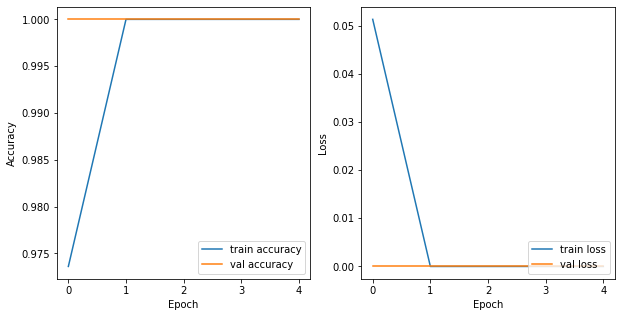

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

As we can observe from the training results the model offers excellent results for this task. As we can observe, the model converges very quickly as it reaches a **training and validation accuracy of 1.00** in the first epoch. This shows a great improvement in comparison with the custom CNN developed in the 7th task.

These results proof that the task was quite simple and the dataset contained similar images.

We will test the model with real time generated data in task 8.

Savinf model to be used in task 8.

In [ ]:
model.save('/content/drive/MyDrive/UCA/ComputerVision/task_9/vgg_model.h5') 
